In [ ]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

from myutils import (get_project_config, get_bus_recording_stats,
                     TimeParser, dataframe_to_bus_records, get_speeds,
                     print_bus_speed_info, get_max_legal_speed,
                     get_max_valid_speed, get_positions_of_interest,
                     get_departure_file_path, get_departures_from_csv,
                     get_bus_recs_of_brigade, Position)

In [2]:
# Load project config from file.
config = get_project_config()
time_format = config.get_time_format()
time_parser = TimeParser(time_format)
stats = get_bus_recording_stats(config, time_parser)

## 1. Number of speeding buses
### 1a. Number of speeding buses

In [3]:
busesdf = pd.read_csv('data/buses.csv',
                    header=None,
                    names=['VehicleNumber', 'Line', 'Brigade', 'Time', 'Lon', 'Lat'])

In [4]:
busesdf.sort_values(by=['VehicleNumber', 'Time'], inplace=True)

In [5]:
bus_recs = dataframe_to_bus_records(busesdf, time_parser)

In [6]:
n_buses = len(set([rec.get_vehicle_number() for rec in bus_recs]))
# Get list of speeds for almost every record (None for first record of each bus).
speeds: list[float | None] = get_speeds(bus_recs)

In [7]:
print_bus_speed_info(list(zip(bus_recs, speeds)),
                     'speeding',
                     get_max_legal_speed(),
                     get_max_valid_speed())
n_invalid_recs = len([s for s in speeds
                      if s is not None and s > get_max_valid_speed()])
print(f'{"%.2f" % (n_invalid_recs / len(speeds) * 100)} % '
      f'of buses breached the maximum valid speed of '
      f'{get_max_valid_speed() * 3.6} km/h.')

There are 1277 (82.55 %) buses that breached the speed of 50.0 km/h.

0.22 % of buses breached the maximum valid speed of 90.0 km/h.


---
### 1b. Positions where many speeding buses were detected

In [10]:
speeding_bus_recs = [x for x in zip(bus_recs, speeds)
                     if x[1] and get_max_legal_speed() < x[1] < get_max_valid_speed()]

In [ ]:
positions_of_interest = [pos
    for pos in get_positions_of_interest(speeding_bus_recs)
    if pos[1] > 0.01 * n_buses]

if len(positions_of_interest) > 0:
    print('The positions where many speeding buses were detected are:')
    for pos in positions_of_interest:
        print(f'Pos: {pos[0]}. N buses: {pos[1]}')
else:
    print('Points where many speeding buses were detected were not found.')

---
## 2. Punctuality of buses

In [30]:
# Iterate through the departure files
# We use the converters parameter to keep the leading zeros.
bus_stops_df = pd.read_csv('data/bus_stops.csv',
                           header=None,
                           names=['StopId', 'StopNum', 'Lat', 'Lon'],
                           converters={'StopId': str, 'StopNum': str})

file_id = 1
path = get_departure_file_path(config, file_id)
print(f'{stats.get_processing_start_time()} - '
      f'{stats.get_processing_end_time()}\n')
n_departures = 0
n_failed_departures = 0
delays = []

# Get Departures from csv
while path.exists():
    print(f'File: {path}')
    for dep in get_departures_from_csv(path, time_parser):
        n_departures += 1
        dep_time = dep.get_time()
        if (dep_time < stats.get_processing_start_time()
            or dep_time > stats.get_processing_end_time()):
            continue
        bus_stop_row = bus_stops_df.loc[
            (bus_stops_df['StopId'] == dep.get_bus_stop_id())
            & (bus_stops_df['StopNum'] == dep.get_bus_stop_number())]
        # Get position
        bus_stop_pos = Position(bus_stop_row['Lat'].values[0],
                                bus_stop_row['Lon'].values[0])
        line_bus_recs = get_bus_recs_of_brigade(
            busesdf,
            dep.get_line(),
            dep.get_brigade(),
            time_parser)
        if len(line_bus_recs) > 0:
            distance_from_bus_stop = [(rec.get_position().distance_to(bus_stop_pos), i)
                                      for i, rec in enumerate(line_bus_recs)]
            closest_rec_i = min(distance_from_bus_stop)[1]
            real_time = line_bus_recs[closest_rec_i].get_time()
            planned_time = dep.get_time()
            delays.append(real_time - planned_time)
        else:
            n_failed_departures += 1
    print(len(delays), n_failed_departures, n_departures)
    file_id += 1
    path = get_departure_file_path(config, file_id)

2024-02-20 09:10:15 - 2024-02-20 10:10:22

File: data/departures/1.csv
190 342 10041
File: data/departures/2.csv
416 636 20065
File: data/departures/3.csv
855 681 30082
File: data/departures/4.csv
1254 767 40131
File: data/departures/5.csv
1579 930 50176
File: data/departures/6.csv
1652 1404 60222
File: data/departures/7.csv
2026 1578 70249
File: data/departures/8.csv
2512 1578 80272
File: data/departures/9.csv
3008 1587 90313
File: data/departures/10.csv
3392 1702 100377
File: data/departures/11.csv
3803 1758 110446
File: data/departures/12.csv
4184 1777 120478
File: data/departures/13.csv
4535 1886 130524
File: data/departures/14.csv
4970 1943 140559
File: data/departures/15.csv
5427 1962 150565
File: data/departures/16.csv
5819 2054 160580
File: data/departures/17.csv
6265 2093 170598
File: data/departures/18.csv
6657 2240 180609
File: data/departures/19.csv
6885 2536 190662
File: data/departures/20.csv
7095 2853 200742
File: data/departures/21.csv
7352 3101 210761
File: data/depart

In [32]:
# Save delays to CSV
with open('analysis/delays.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for delay in delays:
        writer.writerow([delay.total_seconds()])

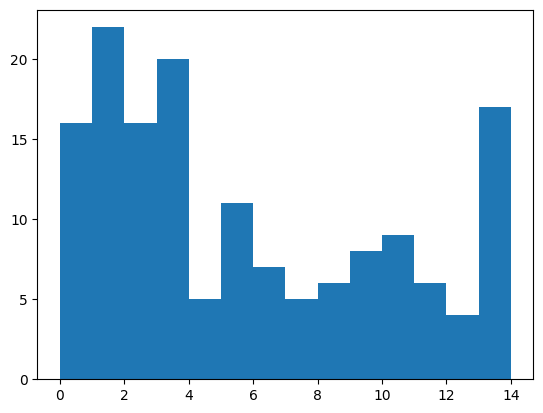

In [33]:
plt.hist([delay.total_seconds() for delay in delays], bins=range(15))
plt.show()

In [35]:
import dill
dill.dump_module('notebook_env.db')

TypeError: cannot pickle '_csv.writer' object